<a href="https://colab.research.google.com/github/VinaySingh561/LARGE-LANGUAGE-MODELS/blob/main/Multi_Head_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

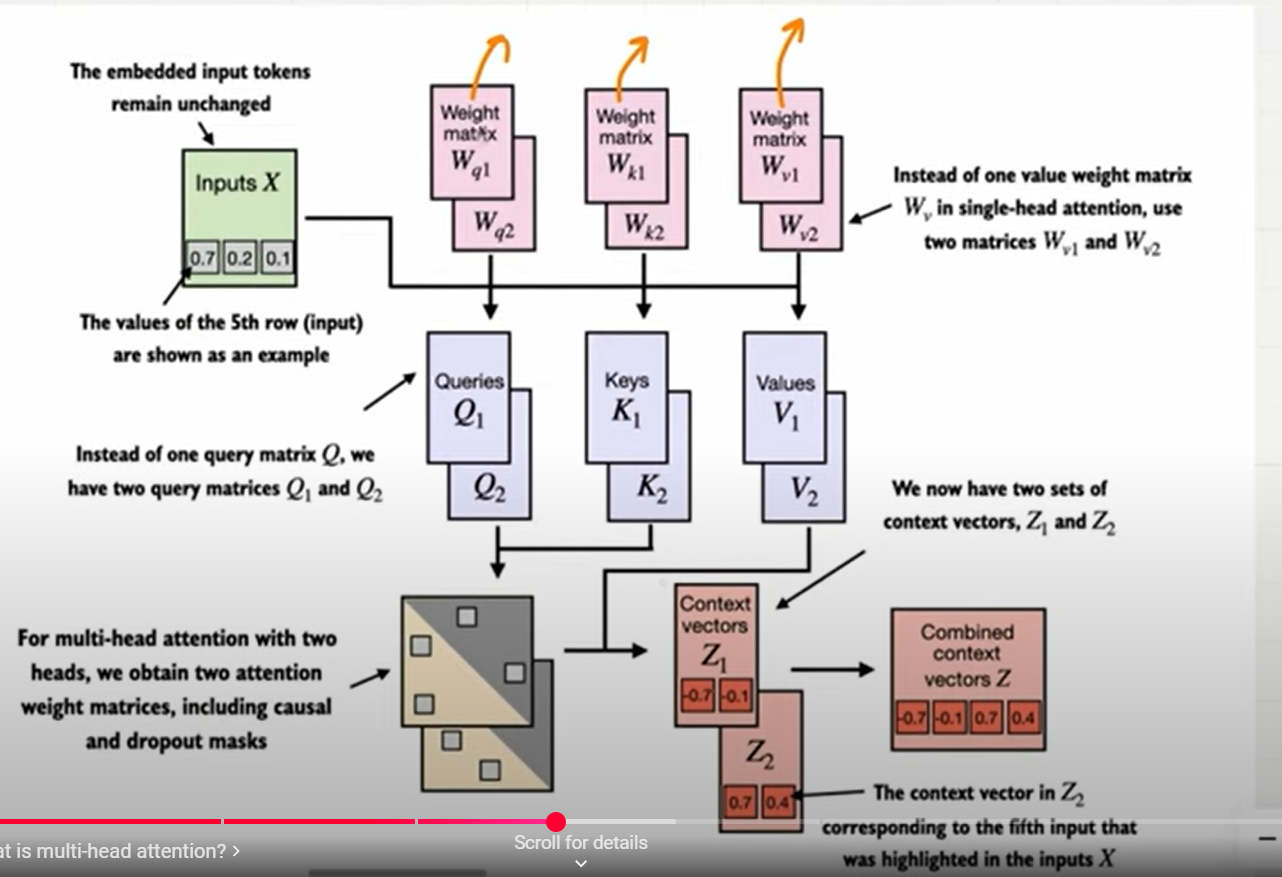

In [41]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

class Causal_attention(torch.nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,qkv_bias = False):
    super().__init__()
    self.W_query = torch.nn.Linear(d_in,d_out,bias = qkv_bias)
    self.W_key = torch.nn.Linear(d_in,d_out,bias = qkv_bias)
    self.W_value = torch.nn.Linear(d_in,d_out,bias = qkv_bias)
    self.dropout = torch.nn.Dropout(dropout)
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # useful when trainng on GPU

  def forward(self,x):
    batch,num_tokens,d_in = x.shape
    Query = self.W_query(x)
    Key = self.W_key(x)
    Value = self.W_value(x)

    attenion_scores = Query@Key.transpose(1,2)
    attenion_scores.masked_fill_(
        self.mask.bool()[:num_tokens,:num_tokens],-torch.inf
    )
    attention_weights = torch.softmax(
        attenion_scores/(Key.shape[1]**0.5),dim=-1
    )
    attention_weights = self.dropout(attention_weights)
    context_vector = attention_weights@Value
    return context_vector


In [42]:
class Multihead_attention(torch.nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias = False):
    super().__init__()
    self.heads = [
        Causal_attention(d_in,d_out,context_length,dropout) for _ in range(num_heads)
    ]

  def forward(self,x):
    return torch.cat([head(x) for head in self.heads],dim=-1)

In [43]:
MA_inputs = torch.stack((inputs,inputs),dim=0)
d_in = 3
d_out = 2
n_heads = 2
context_length  = MA_inputs.shape[1]
dropout = 0.2
MA = Multihead_attention(d_in,d_out,context_length,dropout,n_heads)

In [44]:
context_vector = MA(MA_inputs)
print(context_vector.shape)
print(context_vector)

torch.Size([2, 6, 4])
tensor([[[ 0.1100, -0.1732,  0.1139, -0.5238],
         [ 0.0555, -0.0874, -0.0105, -0.6695],
         [ 0.1533, -0.0410, -0.0397, -0.2647],
         [ 0.2487, -0.0029, -0.0345, -0.5309],
         [ 0.2947,  0.0084, -0.0214, -0.5513],
         [ 0.2332,  0.0077, -0.0468, -0.4363]],

        [[ 0.1100, -0.1732,  0.1139, -0.5238],
         [ 0.2294, -0.0611, -0.0105, -0.6695],
         [ 0.1577, -0.0405, -0.0842, -0.5372],
         [ 0.0680, -0.0301, -0.0702, -0.6551],
         [ 0.2712,  0.0454,  0.0023, -0.3935],
         [ 0.1140, -0.0038, -0.0460, -0.4547]]], grad_fn=<CatBackward0>)


###### In the above code we used different attention single head attention and then finally concatenated context from all the heads which is not very efficient.

Now we will create a single class for multihead attention using weight split methods. Here we will not use different single head , we will create one large weight  matrix, dim = n_heads*dim_out and then we will split it calculate the multiple attention scores from different queries and keys created via split.

In [61]:
class MutliHeadAttention(torch.nn.Module):
  def __init__(self,d_in,d_out,context_length,n_heads,dropout,qkv_bias = False):
    super().__init__()

    assert (d_out % n_heads == 0), \
            "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.n_heads = n_heads
    self.W_query = torch.nn.Linear(d_in, d_out, qkv_bias)
    self.W_key  = torch.nn.Linear(d_in, d_out, qkv_bias)
    self.W_value = torch.nn.Linear(d_in, d_out, qkv_bias)
    self.dropout = torch.nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length, context_length),diagonal = 1)
    )
    self.out_proj = torch.nn.Linear(d_out,d_out)


  def forward(self,x):
    batch,num_tokens,d_in = x.shape
    Query = self.W_query(x) #(batch,num_tokens,d_out)
    Key = self.W_key(x)
    Value = self.W_value(x)

    ## change Q,K,V to (batch,num_tokens, n_heads,n_dim)
    n_dim = self.d_out//self.n_heads
    Q = Query.view(batch,num_tokens,self.n_heads,n_dim)
    K = Key.view(batch,num_tokens,self.n_heads,n_dim)
    V = Value.view(batch,num_tokens,self.n_heads,n_dim)

    ## change Q , K , V to (batch, n_heads, num_tokens, n_dim)  to process head information
    Q = Q.transpose(1,2)
    K = K.transpose(1,2)
    V= V.transpose(1,2)

    ## attention score
    attention_score = Q@K.transpose(2,3)/K.shape[1]**0.5

    ## masking (causal attention)
    masked_bool = self.mask.bool()[:num_tokens,:num_tokens]
    attention_weights = torch.softmax(attention_score.masked_fill_(masked_bool,-torch.inf), dim=-1)  ## (batch,n_heads,num_tokens, num_tokens)
    ## value is (batch, n_heads, num_tokens,n_dim)
    attention_weights  = self.dropout(attention_weights)
    context_vector= attention_weights@V #(batch,n_heads,num_tokens, n_dim)

    ## changing it to (batch, num_tokens,n_heads,n_dim)
    context_vector = context_vector.transpose(1,2)

    ## again (batch,num_tokens, d_out)
    context_vector = context_vector.contiguous().view(batch,num_tokens,self.d_out)

    ## linear layer projection
    context_vector = self.out_proj(context_vector
                                   )
    return context_vector


In [67]:
torch.manual_seed(123)

# Define the tensor with 3 rows and 6 columns
inputs = torch.tensor(
    [[0.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]]  # Row 3
)

MA_inputs = torch.stack((inputs,inputs),dim=0)
d_in = 6
d_out = 6
n_heads = 2
context_length  = MA_inputs.shape[1]
dropout = 0.3
# MA = Multihead_attention(d_in,d_out,context_length,dropout,n_heads)

In [68]:
print(MA_inputs.shape)

torch.Size([2, 3, 6])


In [69]:
Multihead = MutliHeadAttention(d_in,d_out,context_length,n_heads,dropout)

In [70]:
context_vector = Multihead(MA_inputs)

In [71]:
print(context_vector.shape)
print(context_vector)

torch.Size([2, 3, 6])
tensor([[[ 0.0781, -0.2102, -0.0926,  0.0764, -0.4338, -0.3591],
         [ 0.0607, -0.0736, -0.0439, -0.0353, -0.3183, -0.3376],
         [ 0.1448,  0.0073,  0.1517, -0.1042, -0.2680, -0.2355]],

        [[ 0.1977, -0.0472,  0.1369,  0.0174, -0.3335, -0.2281],
         [ 0.0706, -0.1966, -0.1650,  0.0555, -0.3734, -0.3350],
         [ 0.1426, -0.0541, -0.0365, -0.0763, -0.2104, -0.1961]]],
       grad_fn=<ViewBackward0>)
